# Distribución Límite

Sabemos que una distribución $\pi$ es la distribución límite de una cadena de Markov con matriz de transición $P$ si para toda distribución inicial $\pi_0$, se tiene que

$$ \pi = \lim_{n \to \infty} \pi_0 P^n$$

Visualizaremos algunas de las propiedades teóricas de la distribución límite por medio de simulaciones.

Por un teorema, si una cadena de irreducible, recurrente positiva y aperiódica, entonces tiene distribución límite.

**Ejemplo**

Consideremos la cadena de Markov con matriz de transición dada por

Numéricamente estudiaremos el la límite de las potencias $P^n$ para encontrar la distribución límite y después visualizar la convergencia.

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Matriz de transición
P = np.array([
    [0.5, 0.3, 0.2],
    [0.2, 0.5, 0.3],
    [0.3, 0.3, 0.4]
])

# Elevamos la potencia a la 1000000 e imprimimos la distribución numérica
pi_numerical = np.linalg.matrix_power(P, 1000000)[0]
print("Distribución límite (numérica):", pi_numerical)

Distribución límite (numérica): [0.328125 0.375    0.296875]


Ahora veamos cómo se ve esta convergencia

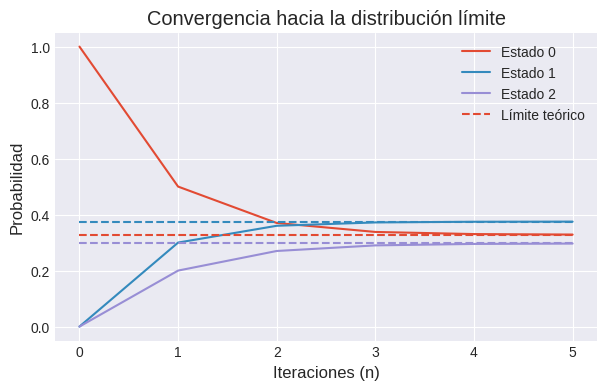

In [26]:
# Definimos la distribución inicial y el número de iteraciones
N = 5
pi0 = np.array([1, 0, 0])  # Empezamos en el estado 0

# Guardamos las distribucioes
history = [pi0]

# Calculamos N valores de la distribución
for _ in range(N):
    pi0 = pi0 @ P
    history.append(pi0)

history = np.array(history)

# Graficamos la evolución
plt.figure(figsize=(7,4))
plt.style.use('seaborn-v0_8-dark')
for i in range(3):
    plt.plot(history[:, i], label=f'Estado {i}')
plt.hlines(pi_numerical, 0, N, linestyles='dashed', colors=['C0', 'C1', 'C2'], label='Límite teórico')
plt.title('Convergencia hacia la distribución límite')
plt.xlabel('Iteraciones (n)')
plt.ylabel('Probabilidad')
plt.legend()
plt.grid(True)
plt.show()


Podemos ver cómo las probabilidades convergen rápidamente.

Actualizaremos el código de nuestra clase CadenadeMarkov para incluir la convergencia a la distribución límite y un gráfico que la iluste.

In [39]:
class CadenaMarkov:

  # Definimos el constructor de la clase
  def __init__(self, P, pi_0):
    self.P = P
    self.pi_0 = pi_0
    self.estados = list(range(len(pi_0))) # Nuevo: Definimos el espacio de estados
    self.proceso = [np.random.choice(range(len(pi_0)), p = pi_0)]

  # Simulamos la cadena igual que antes
  def simular(self, iter):
    for i in range(iter):
      estado_actual = self.proceso[-1]
      xn = np.random.choice(range(len(self.pi_0)), p = self.P[estado_actual])
      self.proceso.append(int(xn))
    return self.proceso

  # Graficamos la trayectoria generada de nuestro proceso
  def plot(self, co):
    plt.figure(figsize=(7,4))
    plt.plot(self.proceso, '-', color = co, ms=1)
    plt.style.use('seaborn-v0_8-dark')
    plt.grid()
    plt.title('Cadena de Markov')
    plt.xlabel('Iteración')
    plt.ylabel('Estado')
    plt.show()

  # Función para calcular m_y, recibe iteraciones de cada trayectoria y número de trayectorias
  def Tiempos_retorno(self, y, iter, trayectorias):
    # Verificamos que el estado esté en el conjunto de estados
    if not y in self.estados:
      return None
    else:
      muestra = []
      # Generamos tantas trayectorias como indiquemos
      for _ in range(trayectorias):
        # Generamos una trayectoria que empiece en el estado que queremos
        cadena_y = CadenaMarkov(self.P, [1 if i == y else 0 for i in range(len(self.pi_0))])
        # Simulamos la trayectoria
        cadena_y.simular(iter)
        # Verificamos el tiempo de retorno de esa trayectoria y lo añadimos a la lista muestra
        for t in range(1, len(cadena_y.proceso)):
          if cadena_y.proceso[t] == y:
            muestra.append(t)
            break
      # Si todo sale bien, devolvemos la media muestral de la muestra de T_y
      if muestra:
        return sum(muestra) / len(muestra)
      else:
        return None

  def distribuciones(self, iter=50):
    # Definimos nuestra lista de distribuciones
    distribuciones = [self.pi_0]
    pi_0 = self.pi_0
    # Iteramos como ya sabemos y guardamos las distribuciones
    for n in range(iter):
        pi_n = np.dot(pi_0, self.P)
        distribuciones.append(pi_n)
        pi_0 = pi_n
    return distribuciones

  def distribucion_estacionaria(self):
    # Por cada estado, calculamos el recíproco de su tiempo medio de recurrencia
    cadena_estado = CadenaMarkov(self.P, self.pi_0)
    est = [1/cadena_estado.Tiempos_retorno(j, 1000, 1000) for j in self.estados]
    return est

  # Recibe un epsilon (1e-6) para verificar la convergencia en un número máximo
  # de iteraciones, max_iter
  def verificar_limite(self, tol=1e-6, max_iter=1000):

    pi = np.array(self.pi_0)
    prev_pi = None # Inicializamos el límite

    # Verificamos si hay convergencia de matrices
    for i in range(max_iter):
        pi_n = np.dot(pi, self.P)
        if prev_pi is not None and np.linalg.norm(pi_n - prev_pi, ord=1) < tol:
            print(f'Converge en {i} iteraciones.')
            return pi_n  # Devuelve la distribución límite numérica
        # Si siguen sin parecerse, sigue el ciclo
        prev_pi = pi_n
        pi = pi_n

    # Esto se da en caso de que no haya convergencia
    print("No converge en el número de iteraciones dado.")
    return pi_n  # Retorna última aproximación

  def plot_limite(self, iter=50):
      distribuciones = self.distribuciones(iter)
      distribuciones = np.array(distribuciones)
      # Ahora hacemos el gráfico de convergencia
      plt.figure(figsize=(7,4))
      plt.style.use('seaborn-v0_8-dark')
      for i in self.estados:
          plt.plot(distribuciones[:, i], label=f'Estado {i}')
      pi_limite = self.verificar_limite()
      for i in self.estados:
          plt.hlines(pi_limite[i], 0, iter, linestyles='dashed', colors=f'C{i}')
      plt.title('Convergencia a la distribución límite')
      plt.xlabel('Iteraciones')
      plt.ylabel('Probabilidad')
      plt.grid()
      plt.legend()
      plt.show()



Ahora probemos el código con nuestro ejemplo

Converge en 10 iteraciones.


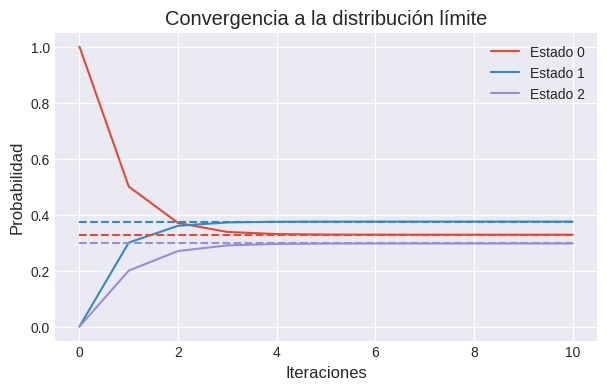

In [40]:
P = np.array([
    [0.5, 0.3, 0.2],
    [0.2, 0.5, 0.3],
    [0.3, 0.3, 0.4]
])

pi0 = [1, 0, 0]

cadena = CadenaMarkov(P, pi0)
cadena.plot_limite(10)

In [27]:
cadena.verificar_limite()

Converge en 10 iteraciones.


array([0.32812506, 0.37499999, 0.29687495])

¡Nuestro código funciona!

**Ejercicios para resolverse numéricamente**

Supongamos que persona se mueve entre tres estaciones de trenes en una ciudad:

* Estación A (estado 0)

* Estación B (estado 1)

* Estación C (estado 2)

Cada día, dependiendo de qué eligió el día anterior, la persona decide cómo se transportará de acuerdo a la siguiente matriz de transición


$P = \begin{bmatrix}
0.6 & 0.3 & 0.1 \\
0.2 & 0.5 & 0.3 \\
0.4 & 0.2 & 0.4 \\
\end{bmatrix}$

Es decir, si hoy está en la estación A, mañana tiene 60% de probabilidad de volver a A, 30% de ir a B y 10% de ir a C, etc.

A largo plazo, ¿qué porcentaje de tiempo estará en cada estación? ¿cuál será la estación que más utilizará?

**Solución**

El problema nos pide encontrar el límite de la probabilidad de estar en cada estación, entonces tenemos que encontrar la distribución límite. Claramente la cadena es irreducible, recurrente positiva y aperiódica.


In [43]:
P_problema1 = np.array([[0.6, 0.3, 0.1],
                        [0.2, 0.5, 0.3],
                        [0.4, 0.2, 0.4]])

# Recuerda nuestra función que genera distribuciones iniciales
def generador_iniciales(n):
  pi_0 = np.random.rand(n) # Crea un array de n valores uniformes(0,1)
  pi_0 = pi_0/sum(pi_0) # Normaliza el vector
  return pi_0

pi_0 = generador_iniciales(3)

cadena_problema1 = CadenaMarkov(P_problema1, pi_0)
cadena_problema1.verificar_limite()

Converge en 12 iteraciones.


array([0.41379308, 0.34482756, 0.24137936])

Converge en 12 iteraciones.


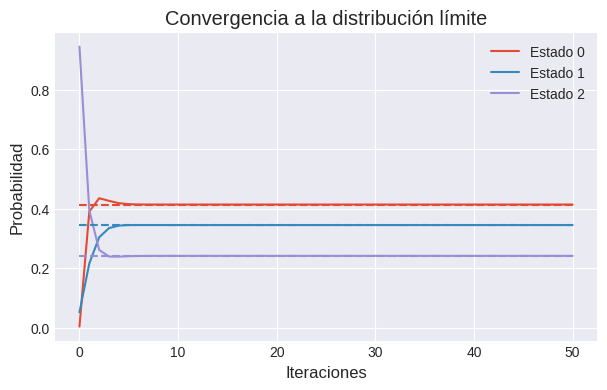

In [44]:
cadena_problema1.plot_limite()

Entonces en promedio estará 41.3% de veces en la estación A, 34.4% en la estación B y 24.3% en la estación C. Esto quiere decir que en general estará más tiempo en la estación A.

**2**

Supongamos que una familia elige una película de Netflix dependiendo de las últimas películas que vieron siguiendo la siguiente regla:

* Si las últimas dos películas que vieron fueron de amor, entonces con probabilidad $\frac{3}{4}$ la siguiente será de amor también.

* Si alguna (o ambas) de las dos últimas películas que vieron fue de terror, entonces con probabilidad $\frac{1}{2}$ eligen una película de amor.

Instrucciones:

1. Modela esto como una cadena de Markov con estados $S = \{ AA, AT, TA, TT\}$ de la siguiente forma:

Si las últimas dos películas que viste fueron de amor, entonce estás en el estado $AA$, y con probabilidad $\frac{3}{4}$ pasas al estado $AA$ de nuevo, pues ves otra película de amor.

Si las últimas dos películas que viste fueron de amor y de terror, entonces estás en el estado $AT$, y solo puedes pasar con probabilidad positiva a los estados $TA$ o $TT$, y a los demás pasas con probabilidad $\frac{1}{2}$.

Es decir, la notación $AA$, $AT$, $TA$, $TT$ indica el género de las últimas dos películas que viste, por lo que el siguiente estado será el género de la película anterior y el género de la película que estás viendo anteriormente.

Observa que el segundo dígito del estado anterior debe ser siempre el primero del estado actual.

2. Clasifica los estados de la cadena.
3. En caso de que la cadena tenga distribución estacionaria, encuéntrala.
4. En caso de que la cadena tenga distribución límite, encuéntrala.

¿Qué género de película es el que más verá la familia a largo plazo?

